In [1]:
from sys import call_tracing
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS, SpectralEmbedding, TSNE, Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import OPTICS, DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
import umap
import mpl_toolkits.mplot3d.axes3d as p3
import os

In [2]:
win_size = 10
use_log = True
use_std = True
# ignore the first day
ignored = 1440

# group_func = 'mean'
group_func = 'mean_and_median'

# umap n_neighbors argument
nn = 50

reducers = {
    'pca': PCA(n_components=3),
    # 'umap': umap.UMAP(n_components=3, metric='cosine', n_neighbors=5, random_state=5566),
    'umap': umap.UMAP(n_components=3, metric='cosine', n_neighbors=nn, random_state=5566),
    # 'umap': umap.UMAP(n_components=3, n_neighbors=15, random_state=5566),
}
# reducer_name = 'pca'
reducer_name = 'umap'
reducer = reducers[reducer_name]
# custom_profile = 'nocustom'
custom_profile = 'cosine-nn%d' % nn
profile = '_'.join([reducer_name, 'log' if use_log else 'nolog', group_func, 'std' if use_std else 'nostd', 'ignore%d' % ignored, custom_profile])
print(profile)

umap_log_mean_and_median_std_ignore1440_cosine-nn50


In [61]:
conv_size = 3
txts = [f for f in os.listdir('./aligned') if f.endswith('.txt')]
monitor_cleaned_smooths = []
act_digests = []
act_origs = []
metas = []

one_meta2 = pd.read_csv('./meta/one_meta2.csv', sep='\t')
# txt = txts[0]
for txt in txts:

    # try:
    #     meta = pd.read_csv('./meta/%s' % txt, sep='\t')
    # except:
    #     continue

    meta = one_meta2[one_meta2.File_Name == os.path.splitext(txt)[0]]
    #meta = one_meta[one_meta.File_Name == 'sdfghjkl;']
    if len(meta) == 0:
        print(txt)
        continue

    monitor = pd.read_csv('./aligned/%s' % txt, sep='\t', header=None)
    monitor = monitor.rename({1:'date', 2:'time'}, axis=1)
    monitor_cleaned = pd.concat([monitor.iloc[:,1:3], monitor.iloc[:,10:]], axis=1)
    monitor_cleaned = monitor_cleaned.iloc[ignored:,:]
    
    #### light dark filter implementation
    #hms = np.array([t.replace(' ', ':').split(':') for t in monitor_cleaned.time], dtype=int)
    #monitor_cleaned['h'] = hms[:,0]
    
    # light
    #monitor_cleaned = monitor_cleaned[(monitor_cleaned.h >= 5) & (monitor_cleaned.h <= 19)].iloc[:,:-1]
    
    # dark 
    #monitor_cleaned = monitor_cleaned[(monitor_cleaned.h <= 5) | (monitor_cleaned.h >= 19)].iloc[:,:-1]
    ####
    
    # monitor_cleaned_smooth = monitor_cleaned.iloc[:,2:].apply(np.convolve, v=np.array([1,1,1,1,1]), mode='valid')
    monitor_cleaned_smooth = monitor_cleaned.iloc[:,2:].apply(np.convolve, v=np.ones(conv_size), mode='valid')
    
    if use_log:
        monitor_cleaned_smooth = np.log(monitor_cleaned_smooth + 1)

    monitor_cleaned_smooth = pd.concat([monitor_cleaned.iloc[(conv_size-1):,:2].reset_index(drop=True), monitor_cleaned_smooth], axis=1)

    hms = np.array([t.replace(' ', ':').split(':') for t in monitor_cleaned_smooth.time], dtype=int)
    monitor_cleaned_smooth['h'] = hms[:,0]
    monitor_cleaned_smooth['mNcell'] = hms[:,1] // win_size
    #monitor_cleaned_smooth = monitor_cleaned_smooth[monitor_cleaned_smooth.h.isin([18,19,20,21,22,23,0,1,2,3,4,5])]
    #monitor_cleaned_smooth['m'] = hms[:,1]
    
    if group_func == 'mean':
        act_digest = pd.concat([monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T, monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T], axis=1)
    else:
        # act_digest = pd.concat([monitor_cleaned_smooth.groupby(['h', 'mNcell']).median().T, monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T], axis=1)
        q1 = monitor_cleaned_smooth.groupby(['h', 'mNcell']).apply(pd.DataFrame.quantile, q=.25).T.iloc[:-2]
        q3 = monitor_cleaned_smooth.groupby(['h', 'mNcell']).apply(pd.DataFrame.quantile, q=.75).T.iloc[:-2]

        monitor_cleaned_smooth_min = monitor_cleaned_smooth.groupby(['h', 'mNcell']).min().T.iloc[2:]
        monitor_cleaned_smooth_max = monitor_cleaned_smooth.groupby(['h', 'mNcell']).max().T.iloc[2:]
        IQR = q3 - q1
        monitor_cleaned_smooth_whisker_min = q1 - 1.5 * IQR
        monitor_cleaned_smooth_whisker_max = q3 + 1.5 * IQR
        
        whisker_min_oob = (monitor_cleaned_smooth_whisker_min < monitor_cleaned_smooth_min)
        whisker_max_oob = (monitor_cleaned_smooth_whisker_max > monitor_cleaned_smooth_max)
        monitor_cleaned_smooth_whisker_min[whisker_min_oob] = monitor_cleaned_smooth_min[whisker_min_oob]
        monitor_cleaned_smooth_whisker_max[whisker_max_oob] = monitor_cleaned_smooth_max[whisker_max_oob]
        
        act_digest = pd.concat([
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T, 
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T,
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).median().T, 
            q1,
            q3,
            monitor_cleaned_smooth_whisker_min,
            monitor_cleaned_smooth_whisker_max,
            ], axis=1)
    
    act_orig = monitor_cleaned_smooth.iloc[:,2:34].T
    #act_digest = monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T / monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T
    #act_digest = monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T
    act_digests.append(act_digest)
    act_origs.append(act_orig)

    metas.append(meta)
    monitor_cleaned_smooths.append(monitor_cleaned_smooth)

meta_union = pd.concat(metas).reset_index(drop=True)
np.sum(meta_union.Instar.isna())
act_digests_npy = np.concatenate(act_digests)
act_origs_npy = np.concatenate(act_origs)
monitor_cleaned_smooths_union = pd.concat(monitor_cleaned_smooths).reset_index(drop=True)

In [62]:
filter_source = (meta_union['Source'] == 'MF') | (meta_union['Source'] == 'WL')

In [63]:
# only select rows where Source = X
# df.loc[df['column_name'] == some_value]
meta_filter = meta_union[filter_source]
#meta_union[filter_source].iloc[:40]

In [64]:
act_filter = act_digests_npy[filter_source]
act_filter.shape

(170, 1008)

In [49]:
act_digests_npy.shape
#act_digests

(512, 1008)

In [65]:
# 3D scatter plot
def scatter3d(data3d, color_map=None, azimuth=-74, elevation=54, figsize=(10, 10)):

    fig = plt.figure(figsize=figsize)
    ax = p3.Axes3D(fig)
    ax.view_init(elevation, azimuth)

    if color_map is None:
        ax.scatter(data3d[:,0], data3d[:,1], data3d[:,2],
                    s=30, edgecolor='k')
    else:
        ax.scatter(data3d[:,0], data3d[:,1], data3d[:,2],
                    color=plt.cm.jet(color_map),
                    s=30, edgecolor='k')
    return ax

def stdscaler (X, use_std=True):
    if use_std:
        return StandardScaler().fit_transform(X)
    else:
        return X

In [66]:
reducer = umap.UMAP(n_components=3, metric='cosine', n_neighbors=nn, random_state=5566)
#reducer = PCA(n_components=3, random_state=5566)

# try:
#     pwdists = pairwise_distances(dr)
# except:
#act_digests_npy = np.concatenate(act_digests)
#act_digests_npy_transformed = stdscaler(act_digests_npy, use_std)
#dr = reducer.fit_transform(act_digests_npy_transformed)

act_filter_transformed = stdscaler(act_filter, use_std)
dr = reducer.fit_transform(act_filter_transformed)
act_filter_transformed.shape
dr.shape
# reducer.fit(act_digests_npy_transformed)
# reducer.transform(act_digests_npy_transformed)
pwdists = pairwise_distances(dr)

pwdists.shape

(170, 170)

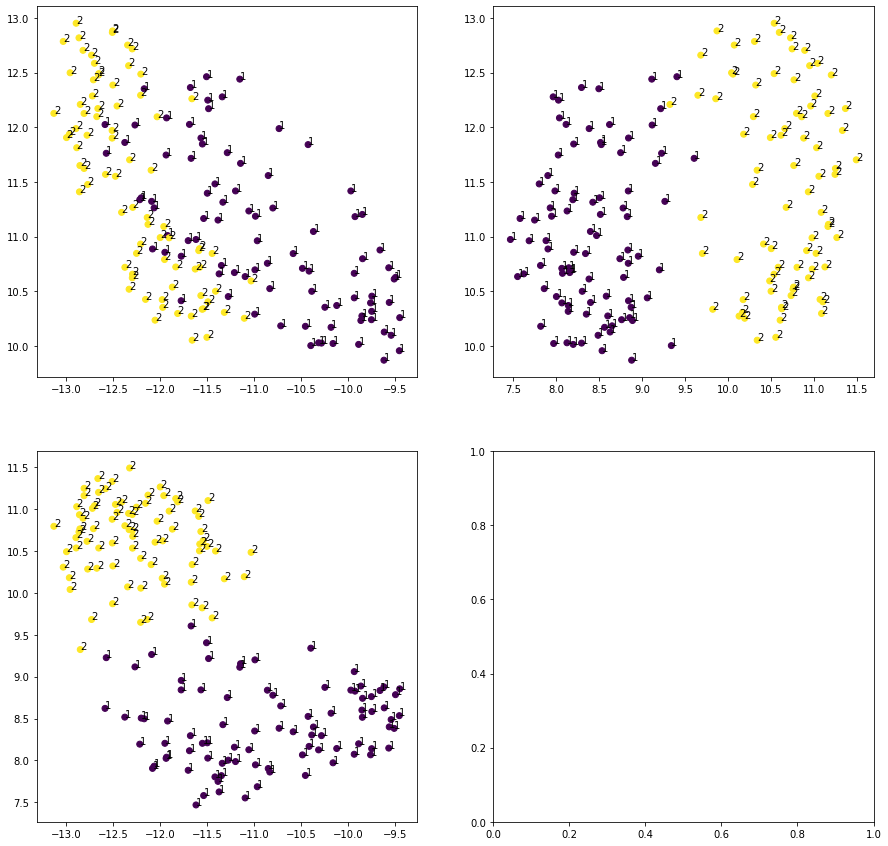

In [67]:
min_samples = 20

shortest_dists_mean = np.take_along_axis(pwdists, np.argsort(pwdists)[:,1:(1+min_samples)], axis=1).mean(axis=1)
shortest_dists_mean_std = shortest_dists_mean.std()
eps = shortest_dists_mean.mean() + 2 * shortest_dists_mean_std

clusterer = DBSCAN(eps=eps, min_samples=min_samples)
group_idxs_ = clusterer.fit_predict(dr) + 1
group_idxs = group_idxs_[group_idxs_ > 0]
dr_wg = dr[group_idxs_ > 0]
gcolor_map = group_idxs / (group_idxs.max() + 1)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0][0].scatter(dr_wg[:,0], dr_wg[:,1], c=gcolor_map)
axs[0][1].scatter(dr_wg[:,2], dr_wg[:,1], c=gcolor_map)
axs[1][0].scatter(dr_wg[:,0], dr_wg[:,2], c=gcolor_map)
for tid in range(dr_wg.shape[0]):
    axs[0][0].text(dr_wg[tid,0], dr_wg[tid,1], group_idxs[tid])
    axs[0][1].text(dr_wg[tid,2], dr_wg[tid,1], group_idxs[tid])
    axs[1][0].text(dr_wg[tid,0], dr_wg[tid,2], group_idxs[tid])
plt.show()

In [72]:
meta_filter.shape

(170, 28)

In [81]:
# adding a group column, organizing the scatterplot group 1,2 into data table
meta_filter_with_group = meta_filter.copy()
meta_filter_with_group['group'] = group_idxs_
meta_filter_with_group#[group_idxs_ == 1].iloc[:50]
# meta_filter_with_group[group_idxs_ == 0] 
# 2 WL indivs belong to group 0 (outliers)

,ExpID,File_Name,Env,Setup,LD_cycle,Num,ID,Nest,Source,Location,...,End_Date,Soil,Bury,Eggs,Instar,Distance,Carcass,Phenotype,expression,group
32,Loc1001,Monitor20201001_1005_soil,warmroom,soil,LD_4,1,S9519,n7582,WL,11_7,...,10/13/20,10.187,0.0,0.0,0.0,1.13,0.0,s,NaN,0
422,Loc0107-2,Monitor20210107_0111(2)_edit,long,soil,LD_4,7,T2576,n7976,WL,S9507_S9277,...,2/9/21,9.620,1.0,1.0,1.0,on carcass,1.0,NaN,NaN,0


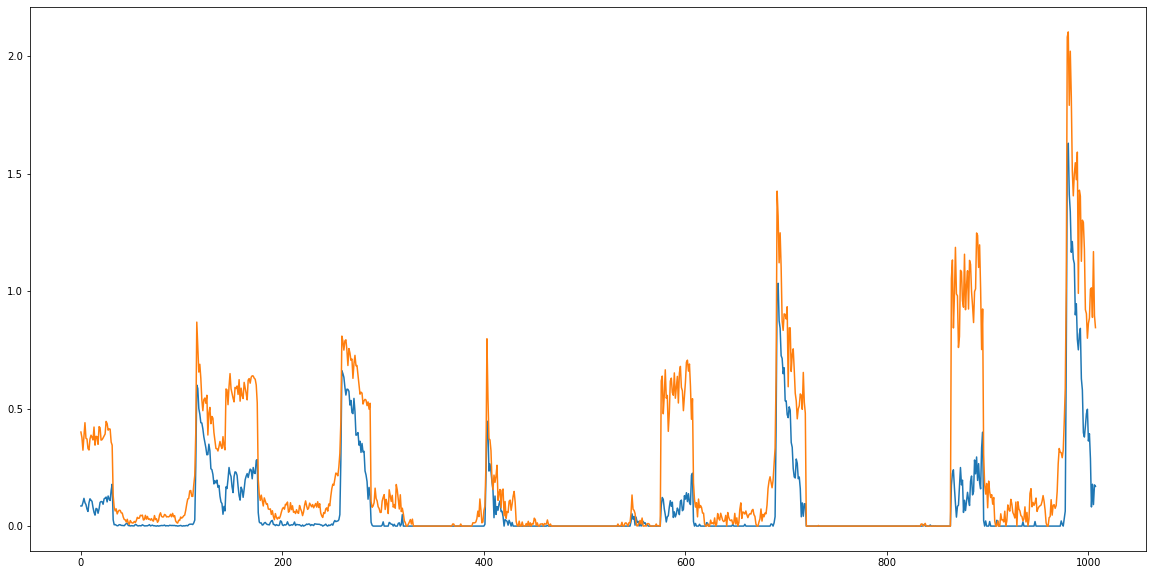

In [85]:
plt.figure(figsize=(20,10))
#plt.plot(act_filter[group_idxs_ == 0].mean(axis=0)) #blue
plt.plot(act_filter[group_idxs_ == 1].mean(axis=0)) #orange
plt.plot(act_filter[group_idxs_ == 2].mean(axis=0)) #green